In [2]:
from naginterfaces.library import opt
from naginterfaces.base import utils
import numpy as np
import networkx as nx  
import matplotlib.pyplot as plt
import warnings

# Compute the Lovasz $\theta$ number of a graph using Semi-Definite Programming (SDP)

## Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

## Introduction

The Lovasz number allows to compute an upper bound on the Shannon capacity of a graph $G$ (the maximum size of independent sets of vertices in G). While the complexity of computing the Shannon capacity is not known, the Lovasz number can be efficiently computed in polynomial time via SDP. 

Start by defining a graph $G = (V, E)$

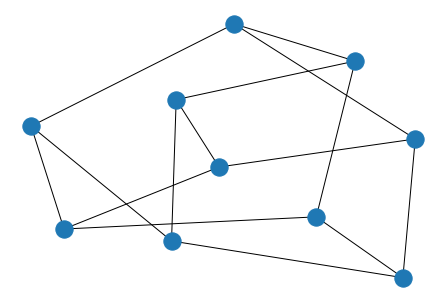

In [3]:
warnings.simplefilter("ignore")
nv = 10 # number of vertices
ne = 15 # number of edges
G = nx.Graph()
G.add_edges_from([(1,2), (2,3), (3,4), (4,5), (1,5), (1,6), (2,7), (3,8),
                  (4,9), (5,10), (6,8), (6,9), (7,9), (7,10), (8,10)])
ed = list(G.edges)
nx.draw(G, with_labels=False) 

The $\theta$ function can be expressed in various ways, here we use the following:
\begin{equation*}
\theta_G = \min\{\lambda_{max}(H) / H \in \mathbb{S}^n ,  s_{ij} = 1 \text{ if } i=j \text{ or if } (i,j) \notin E \} 
\end{equation*}
where $n$ is the number of vertices $|V|$ and $\mathbb{S}^n$ is the space of $n \times n$ symmetric matrices

The problem can therefore be written as:
\begin{equation*}
\min_{t,H} t\\
\text{s.t. } H \preceq tI\\
H \in \mathbb{S}^n, s_{ij} = 1 \text{ if } i=j \text{ or if } (i,j) \notin E 
\end{equation*}
which can in turn be transformed int the solver-friendly form:
\begin{equation*}
\min_{t,x} t\\
\text{s.t. } tI + \sum_{ij \in E} x_{ij}E_{ij} - J \succeq 0
\end{equation*}
where $J$ is a matrix of all ones and $E_{ij}$ is a matrix of all zeros except $(i,j)$ and $(j,i).

In [4]:
# Initialize the handle
nvar = ne + 1
handle = opt.handle_init(nvar)

In [5]:
# Define the objective function: min_{t,H} t
cvec = np.zeros(nvar, dtype=float)
cvec[0] = 1
opt.handle_set_linobj(handle, cvec)

In [6]:
# Generate matrix constraint as:
# sum_{ij is edge in G} x_ij*E_ij + t*I - J >=0 where J is the all-ones matrix.
dima = nv

# Total number of nonzeros
nnzasum = int(ne + nv + (nv+1)*nv/2)

nnza = np.empty(nvar+1, dtype=int)
irowa = np.empty(nnzasum, dtype=int)
icola = np.empty(nnzasum, dtype=int)
a = np.empty(nnzasum, dtype=float)

# A_0 is all ones matrix
nnza[0] = (nv+1)*nv/2
idx = 0
for i in range(nv):
    for j in range(i, nv):
        irowa[idx] = i + 1
        icola[idx] = j + 1
        a[idx] = 1.0
        idx += 1
        
# A_1 is the identity
nnza[1] = nv
for i in range(nv):
    irowa[idx] = i + 1
    icola[idx] = i + 1
    a[idx] = 1.0
    idx += 1
# A_2, A_3, ..., A_{ne+1} match the E_ij matrices
nnza[2:ne+2] = 1
for i in range(ne):
        irowa[idx] = ed[i][0]
        icola[idx] = ed[i][1]
        a[idx] = 1.0
        idx += 1

idblk = opt.handle_set_linmatineq(handle, dima, nnza, irowa, icola, a, 
                                  blksizea=None, idblk=0)

In [7]:
# I/O
iom = utils.FileObjManager(locus_in_output=False)

# Set optional argument
for option in ['Print Options = No',
               'Initial X = Automatic']:
    opt.handle_opt_set(handle, option)
    
x = np.empty(nvar)
inform = 0
x, _, _, _, rinfo, stats, _ = opt.handle_solve_pennon(handle, x, inform, u=None, 
                                                      uc=None, ua=None, io_manager=iom)

 E04SV, NLP-SDP Solver (Pennon)
 ------------------------------
 Number of variables            16                 [eliminated            0]
                            simple  linear  nonlin
 (Standard) inequalities         0       0       0
 (Standard) equalities                   0       0
 Matrix inequalities                     1       0 [dense    1, sparse    0]
                                                   [max dimension        10]

 --------------------------------------------------------------
  it|  objective |  optim  |   feas  |  compl  | pen min |inner
 --------------------------------------------------------------
   0  0.00000E+00  4.71E+01  1.00E+01  4.81E+01  1.60E+01   0
   1  9.55399E+01  9.29E-03  0.00E+00  9.52E+01  1.60E+01   8
   2  3.93849E+01  1.16E-03  0.00E+00  3.81E+01  6.63E+00   5
   3  1.68392E+01  1.19E-02  0.00E+00  1.52E+01  2.75E+00   3
   4  8.50544E+00  7.32E-04  0.00E+00  5.78E+00  1.14E+00   4
   5  5.62254E+00  1.56E-02  0.00E+00  2.07E+00  

In [8]:
print('The Lovasz number of the graph G is: {0:2f}'.format(rinfo[0]))

The Lovasz number of the graph G is: 4.000000


In [ ]:
help(opt.handle_solve_pennon)